In [62]:
import os
import uuid

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from PIL import Image

In [33]:
data = "../data"
datasets = ['DeepGlobe-dataset', "Massachusetts-roads-dataset"]
dataset_out = "../data/big-dataset"

In [34]:
im = Image.open(os.path.join(data, datasets[0], "train", "104_mask.png"))
im.size

(1024, 1024)

In [35]:
# get patches of size (400, 400) from the image
def get_patches(im, size):
    patches = []
    for i in range(0, im.size[0] - size[0], size[0]//2):
        for j in range(0, im.size[1] - size[1], size[1]//2):
            patches.append(im.crop((i, j, i + size[0], j + size[1])))
    return patches

patches = get_patches(im, (400, 400))

# Generate Patches from DeepGlobe

In [35]:
dataset = datasets[0]

# get unique names
fnames = os.listdir(os.path.join(data, dataset, "train"))
fnames = list({name.split("_")[0] for name in fnames})

In [38]:
for fname in tqdm(fnames):
    img = Image.open(os.path.join(data, dataset, "train", f"{fname}_sat.jpg"))
    target = Image.open(os.path.join(data, dataset, "train", f"{fname}_mask.png"))

    # get patches of size (400, 400) from the image
    img_patches = get_patches(img, (400, 400))
    target_patches = get_patches(target, (400, 400))

    # save patches to disk
    idx = uuid.uuid4()
    for i in range(len(img_patches)):
        if np.sum(target_patches[i]) > 0:
            img_patches[i].save(os.path.join(data, dataset_out, "train/images", f"{idx}-{i}.jpg"))
            target_patches[i].save(os.path.join(data, dataset_out, "train/groundtrouth", f"{idx}-{i}-mask.jpg"))

100%|██████████| 6226/6226 [08:53<00:00, 11.68it/s]


# Generate Patches from MRD

In [30]:
dataset = f"{datasets[1]}/tiff"
dataset_out = dataset_out


for split in ["train", "test", "val"]:
    # get unique names
    fnames = os.listdir(os.path.join(data, dataset, split))
    
    for fname in tqdm(fnames):
        # load .tiff image
        img = Image.open(os.path.join(data, dataset, split, fname))

        # img = Image.open(os.path.join(data, dataset, "train", f"{fname}"))
        target = Image.open(os.path.join(data, dataset, f"{split}_labels", f"{fname}"[:-1]))

        # get patches of size (400, 400) from the image
        img_patches = get_patches(img, (400, 400))
        target_patches = get_patches(target, (400, 400))

        idx = uuid.uuid4()
        for i in range(len(img_patches)):
            keep = np.array(img_patches[i]).mean(axis=-1) > 254
            s = np.sum(keep)
            if s < 100 and np.sum(target_patches[i]) > 0:
                img_patches[i].save(os.path.join(data, dataset_out, "MRD", "images", f"{idx}-{i}.jpg"))
                target_patches[i].save(os.path.join(data, dataset_out, "MRD", "groundtrouth", f"{idx}-{i}-mask.jpg"))

100%|██████████| 14/14 [00:04<00:00,  3.25it/s]


# Prepare CIL Data

In [49]:
data = "../data/big-dataset"
dataset = "CIL"
load_data = "../data/CIL-dataset/training"

for fname in tqdm(os.listdir(os.path.join(load_data, "images"))):
    if fname.endswith(".png"):
        img = Image.open(os.path.join(load_data, "images", fname))
        target = Image.open(os.path.join(load_data, "groundtruth", fname))

        # convert image to jpg
        img = img.convert("RGB")
        target = target.convert("RGB")
        
        img.save(os.path.join(data, dataset, "images", f"{fname.split('.')[0]}.jpg"))
        target.save(os.path.join(data, dataset, "groundtruth", f"{fname.split('.')[0]}-mask.jpg"))

100%|██████████| 144/144 [00:01<00:00, 90.46it/s]


# Explore Datasets

In [51]:
data = "../data/big-dataset"
df = []

for dataset in ["MRD", "DeepGlobe", "CIL"]:
    masks = os.listdir(os.path.join(data, dataset, "groundtruth"))
    for i, mask in tqdm(enumerate(masks), total=len(masks)):
        if mask.endswith("-mask.jpg"):
            n_pixels = np.sum(np.array(Image.open(os.path.join(data, dataset, "groundtruth", mask))) > 0)
            df.append((mask, dataset, n_pixels))

100%|██████████| 145/145 [00:00<00:00, 678.65it/s]


In [52]:
dataframe = pd.DataFrame(df, columns=["filename", "dataset", "n_pixels"])
dataframe.head()

,filename,dataset,n_pixels
0,b91aaeca-0f41-4b5e-8634-e552e7ac813a-15-mask.jpg,MRD,12819
1,a249b55f-b1a6-40fd-869a-ac1f9006c35d-27-mask.jpg,MRD,4239
2,cc10526b-21ee-45b4-aee8-e1fab1ec2cab-31-mask.jpg,MRD,27584
3,8d48925b-ce40-40c1-af67-c329a54efa6d-4-mask.jpg,MRD,6973
4,3d36175c-9ce7-45c6-9e91-654ab0a2ce11-21-mask.jpg,MRD,13963


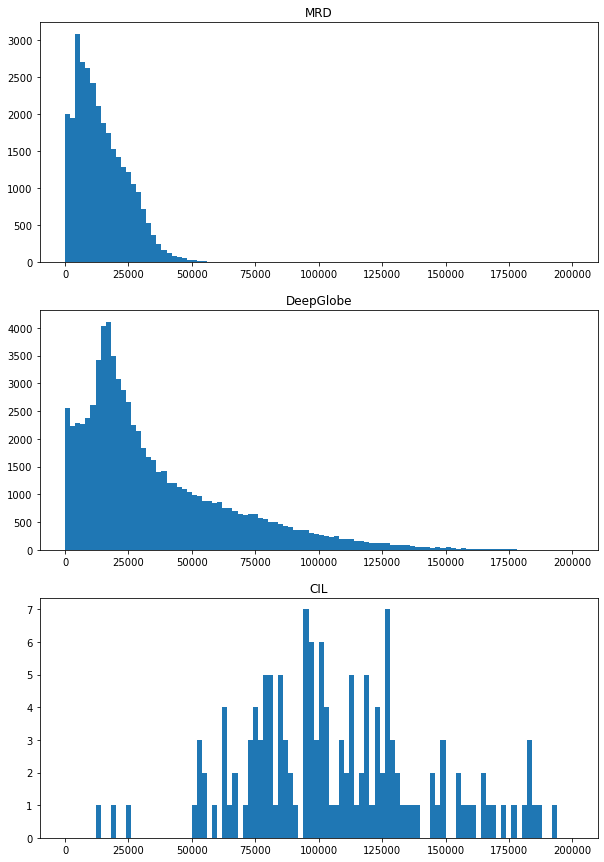

In [90]:
# plot hist per dataset of n_pixels in different plots using plt
plt.figure(figsize=(10, 15))
for i, dataset in enumerate(["MRD", "DeepGlobe", "CIL"]):
    plt.subplot(3, 1, i + 1)
    plt.hist(dataframe[dataframe["dataset"] == dataset]["n_pixels"], bins=100, range=(0, 200000))
    plt.title(dataset)

In [95]:
# count how many masks have more than count pixels
count = 10000
dataframe[dataframe["n_pixels"] > count].groupby("dataset").count()


,filename,n_pixels
dataset,,
CIL,144,144
DeepGlobe,63409,63409
MRD,18146,18146
